In [1]:
#Test notebook for tracking rigid body  marker consisting of multiple fiducials within a CT scan volume

#3D data processing
import open3d as o3d
import ct_tracking_library # our helper functions
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
from ipywidgets import interact, fixed

#our processing code
from ct_tracking_library.ct_motor_functions import *
from ct_tracking_library.ct_tracking_functions import *
from ct_tracking_library.ct_processing_functions import *
from ct_tracking_library.ct_display_functions import *
from ct_tracking_library.ct_object_classes import *
from ct_tracking_library.ct_fk_functions import *

#used for GUI
%matplotlib notebook

#find transform
import datetime
import time
import pickle
from spatialmath import *
from roboticstoolbox import ET as E
import transforms3d as t3d
import itertools

In [2]:
def get_marker(selected_series,time,v = False, debug = False):
    """
    This function finds the marker from the user sleceted dicom file:

    Args:
        selected_series(string): the serial key for the slected DICOM.
        time(Time): time intial when the function is called.
        v(bool): to show visualization for the marker
        debug(bool): wheather or not the user want to see debug info.

    Returns:
        M_list[0](Marker): the moveing marker object finded
        M_list[1](Marker): the fixed marker object finded
        v_mesh(Open3d mesh): the mesh used for finding the marker in form of open3d

    """
    M_list = []
    data_directory = "./test_data/DICOM"
    file_reader = sitk.ImageFileReader()
    series_file_names = {}
    series_IDs = list(sitk.ImageSeriesReader_GetGDCMSeriesIDs(data_directory))
    if series_IDs:
        for series in series_IDs:
            series_file_names[series] = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory, series)
    for S in range(2):
        # pick marker
        if S == 0:
            target_marker_name = 'moving_marker_1_DoF'
            marker = np.array([[-10,-5,0],[-10,5,0],[0,-5,0],[10,0,0]])
            R = np.eye(3)
            crop_z = None
        else:
            target_marker_name = 'fixed_marker_1_DoF'
            marker = np.array([[0,-14,0],[0,-6,0],[0,16,0],[17,0,0]])
            R = np.eye(3)
            crop_z = None

        #convert scan to mesh for finding markers via thresholding
        scan_file = series_file_names[selected_series]
        convert_scan_to_mha(scan_file, crop_z = crop_z)
        convert_mha_to_mesh(output_mesh_file = 'temp_mesh.obj')

        #find candidate fiducials within the scanner returning clustered centroids that could be rigid body markers
        _, marker_centroid_coordinates, pcd_selected, marker_mesh, _, good_centroid_clusters = find_candidate_centroids(marker = marker, debug=debug)
        if debug:
            print('marker centroid coordinates from design: {}'.format(marker))
            print('found centroid coordinates: {}'.format(marker_centroid_coordinates))

        #display candidate fiducials
        if v:
            o3d.visualization.draw_geometries([pcd_selected, marker_mesh])

        #find best transform and marker from candidate fiducials
        tracked_R, tracked_t, permuted_centroids, min_error = find_best_transform_from_candidate_marker_clusters(marker, good_centroid_clusters)

        #get rid of column of ones to make 3xN
        permuted_centroids = permuted_centroids[:3,:].T

        #transform marker geometry coordinates using found transform to tracked image coordinates
        transformed_marker = (tracked_R @ marker.T + tracked_t).T
        error = permuted_centroids-transformed_marker
        
        #tracking error from final transform
        np.set_printoptions(2)
        print("Error (mm): {}".format(error))
        print("Error norm (mm): {}".format(np.linalg.norm(error)))
        if v:
            #create o3d visualizations
            marker_3d_tracked = create_marker_visualization(fiducial_coordinates=permuted_centroids, color=[0.8, 0.2, 0.2])
            marker_3d_base = create_marker_visualization(marker, [0.2, 0.8, 0.2])
            marker_3d_base.append(create_coordinate_frame_visualization())
            marker_3d_transformed = create_marker_visualization(marker, [0.2, 0.2, 0.8], tracked_R, tracked_t)
            marker_3d_transformed.append(create_coordinate_frame_visualization(tracked_R, tracked_t))
            #visualize tracked markers on top of mesh used for tracking
            visualization_list2 = marker_3d_tracked+marker_3d_base+marker_3d_transformed + [marker_mesh]
            visualization_list1 = copy.deepcopy(visualization_list2)
            o3d.visualization.draw_geometries(visualization_list2)
        if S == 0:
            v_mesh= marker_mesh
        #append marker
        print("T find: ",tracked_t)
        M_list.append(Marker(name=target_marker_name,d_key=selected_series,time =time,geometry=marker,T=t2T(tracked_R, tracked_t),error=np.linalg.norm(error, axis=1)))
        
    return M_list[0],M_list[1],v_mesh

In [3]:
def plot3l(x_l,y_l,z_l,R):
    plt.figure()
    plt.plot(range(len(x_l)),x_l,linestyle='--', marker='o')
    plt.plot(range(len(y_l)),y_l,linestyle='--', marker='o')
    plt.plot(range(len(z_l)),z_l,linestyle='--', marker='o')
    plt.xlabel("Scan #")
    if R == True:
        plt.ylabel("Euler Angle Degree")
        plt.title("Scan # Vs. Degree")
        plt.legend(['r', 'θ','Φ'])
    else:
        plt.ylabel("Distance(mm)")
        plt.title("Scan # Vs. Distance")
        plt.legend(['X', 'Y','Z'])
    plt.show()

In [5]:
with open('data4.pkl', 'rb') as f:
    new_data = pickle.load(f)

In [ ]:
u_list = [0,25,50,75]
key_list = ['1.2.840.113619.2.416.6795503943617817801219389912763296544',
           '1.2.840.113619.2.416.6091776499222851246423953174468199664',
           '1.2.840.113619.2.416.100083941475652116358255918161510130375',
           '1.2.840.113619.2.416.61935088023485344866325542289366845877']
ratio = 0.5040628051757813 #converting mm to rev

## Created new_data

In [ ]:
new_data = {}
mesh_l=[]
for x in range(len(u_list)):
    selected_keys = key_list[x]
    name = 'scan'+str(x)
    marker1,marker2,mesh = get_marker(selected_keys,data_load[name][0].time)
    mesh_l.append(mesh)
    robot = data_load[name][2]
    append_value(new_data, "scan"+str(x), marker1)
    append_value(new_data, "scan"+str(x), marker2)
    append_value(new_data, "scan"+str(x), robot)

## Plots

<IPython.core.display.Javascript object>


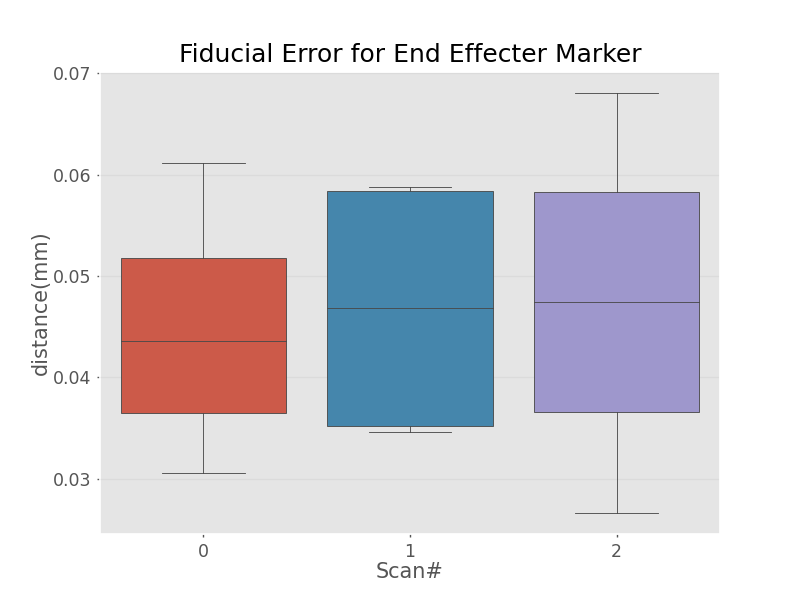

<IPython.core.display.Javascript object>


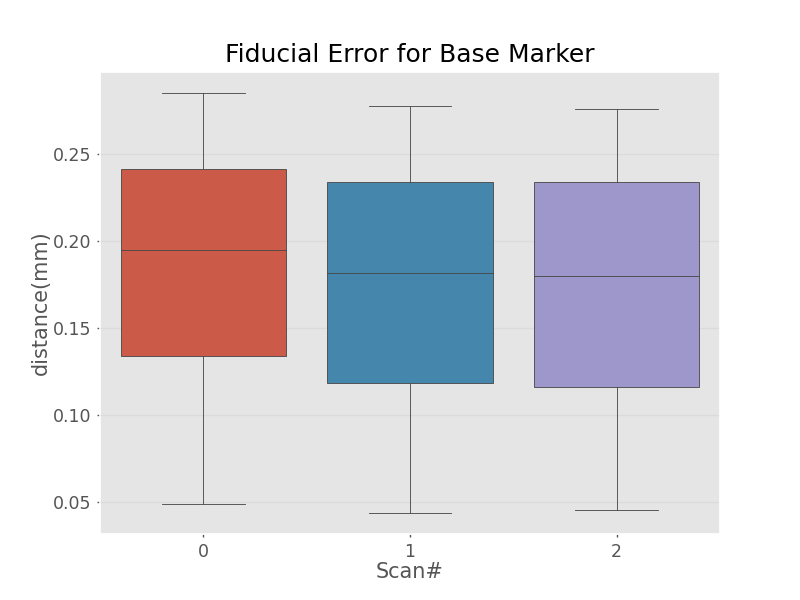

[Text(0.5, 1.0, 'Fiducial Error for Base Marker'),
 Text(0, 0.5, 'distance(mm)'),
 Text(0.5, 0, 'Scan#')]

In [6]:
ee_list = []
b_list = []
for y in new_data:
    ee_list.append(new_data[y][0].error)
    b_list.append(new_data[y][1].error)
sns.boxplot(data=ee_list,  orient='v').set(title='Fiducial Error for End Effecter Marker',ylabel="distance(mm)",xlabel="Scan#")
plt.figure()
sns.boxplot(data=b_list,  orient='v').set(title='Fiducial Error for Base Marker',ylabel="distance(mm)",xlabel="Scan#")

In [7]:
marker = np.array([[0,-14,0],[0,-6,0],[0,16,0],[17,0,0]])
R = np.eye(3)
visualization_list = [mesh]
color = [.8, .6, .8]
for x in new_data:
    print(x)
    marker_3d_tracked = create_marker_visualization(marker, color, SE3(new_data[x][1].T).R, SE3(new_data[x][1].T).t.reshape((3,1))) #blue color
    visualization_list += marker_3d_tracked
    color = [y-.2 for y in color]
o3d.visualization.draw_geometries(visualization_list)

scan0
scan1
scan2


TypeError: draw_geometries(): incompatible function arguments. The following argument types are supported:
    1. (geometry_list: List[open3d.cpu.pybind.geometry.Geometry], window_name: str = 'Open3D', width: int = 1920, height: int = 1080, left: int = 50, top: int = 50, point_show_normal: bool = False, mesh_show_wireframe: bool = False, mesh_show_back_face: bool = False) -> None
    2. (geometry_list: List[open3d.cpu.pybind.geometry.Geometry], window_name: str = 'Open3D', width: int = 1920, height: int = 1080, left: int = 50, top: int = 50, point_show_normal: bool = False, mesh_show_wireframe: bool = False, mesh_show_back_face: bool = False, lookat: numpy.ndarray[float64[3, 1]], up: numpy.ndarray[float64[3, 1]], front: numpy.ndarray[float64[3, 1]], zoom: float) -> None

Invoked with: [<module 'stl.mesh' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\stl\\mesh.py'>, TriangleMesh with 762 points and 1520 triangles., TriangleMesh with 762 points and 1520 triangles., TriangleMesh with 762 points and 1520 triangles., TriangleMesh with 762 points and 1520 triangles., TriangleMesh with 762 points and 1520 triangles., TriangleMesh with 762 points and 1520 triangles., TriangleMesh with 762 points and 1520 triangles., TriangleMesh with 762 points and 1520 triangles., TriangleMesh with 762 points and 1520 triangles., TriangleMesh with 762 points and 1520 triangles., TriangleMesh with 762 points and 1520 triangles., TriangleMesh with 762 points and 1520 triangles.]

<IPython.core.display.Javascript object>


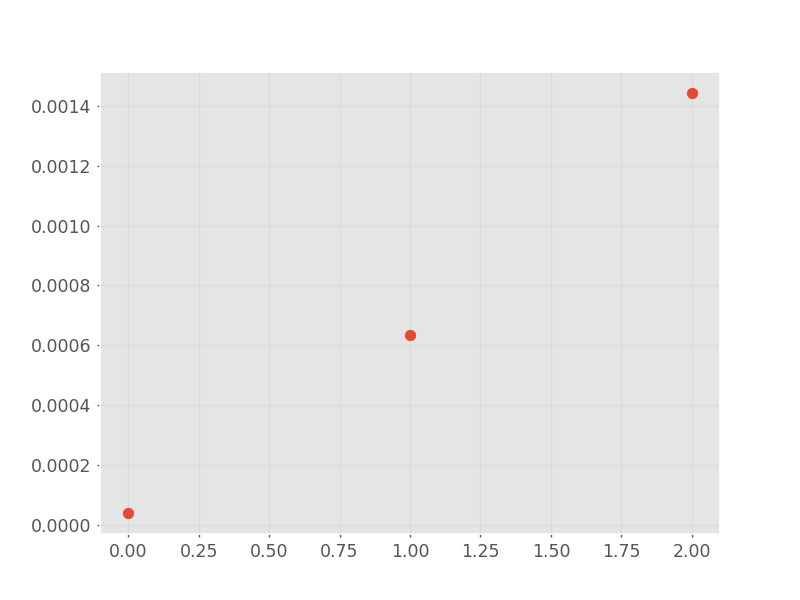

<IPython.core.display.Javascript object>


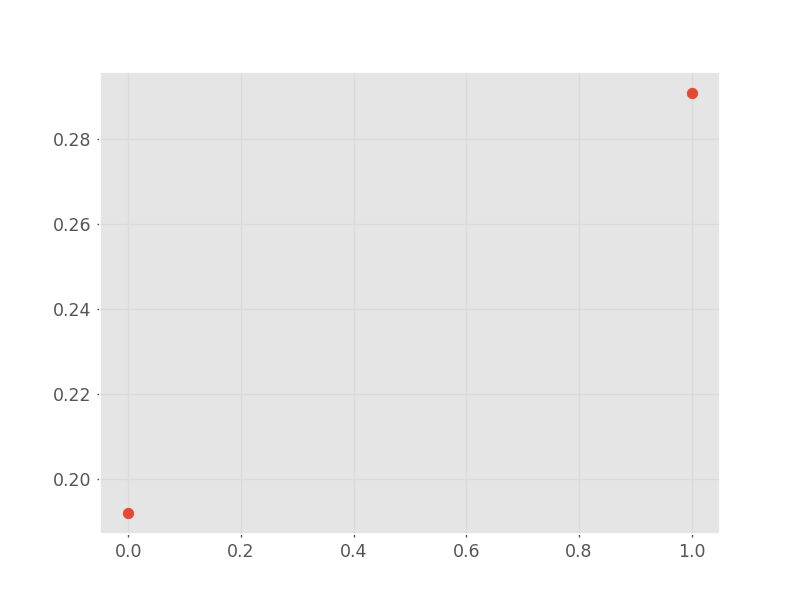

In [8]:
pn = calc_p_error(SE3(new_data['scan1'][1].T).t,SE3(new_data['scan0'][1].T).t)
rn = calc_needle_ori_error(SE3(new_data['scan1'][1].T).R,SE3(new_data['scan0'][1].T).R)
for x in dict(itertools.islice(new_data.items(), 2,4)):
    pn = np.hstack((pn,calc_p_error(SE3(new_data[x][1].T).t,SE3(new_data['scan0'][1].T).t)))
    rn = np.vstack((rn,calc_needle_ori_error(SE3(new_data[x][1].T).R,SE3(new_data['scan0'][1].T).R)))
pnn = np.linalg.norm(pn, axis=0)
rnn = np.linalg.norm(rn, axis=0)
plt.figure()
plt.scatter(range(len(rnn)),rnn)
plt.figure()
plt.scatter(range(len(pnn)),pnn)

### Tsb Base Verfied Plot

<IPython.core.display.Javascript object>


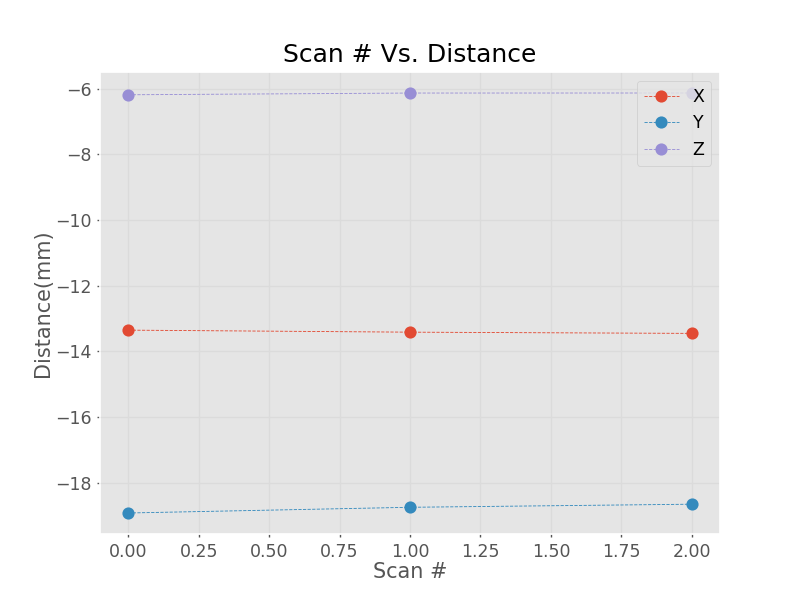

<IPython.core.display.Javascript object>


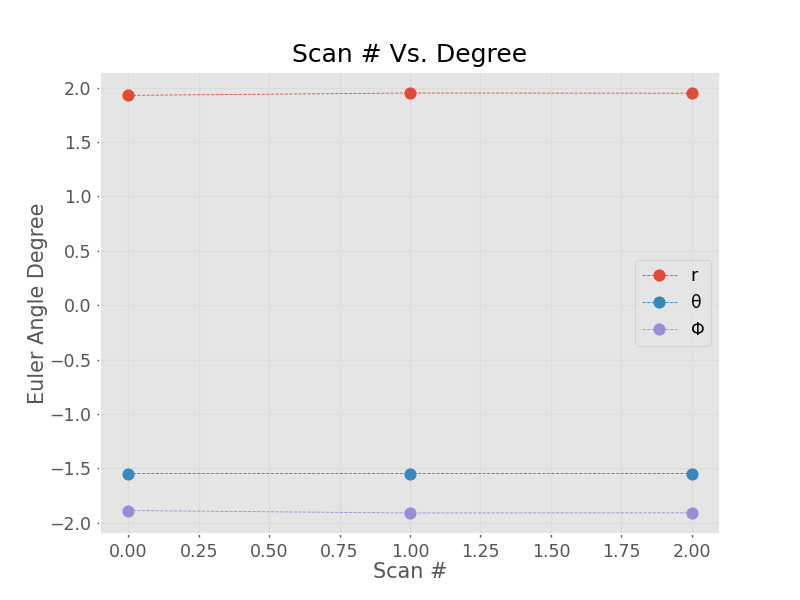

In [9]:
x_l = []
y_l = []
z_l = []
x_r = []
y_r = []
z_r = []
for x in new_data:
    pos = SE3(new_data[x][1].T).t
    ros = R2E(SE3(new_data[x][1].T).R)
    x_l.append(pos[0])
    y_l.append(pos[1])
    z_l.append(pos[2])
    x_r.append(ros[0])
    y_r.append(ros[1])
    z_r.append(ros[2])
plot3l(x_l,y_l,z_l,False)
plot3l(x_r,y_r,z_r,True)

### Tb EE Verfied Plot

<IPython.core.display.Javascript object>


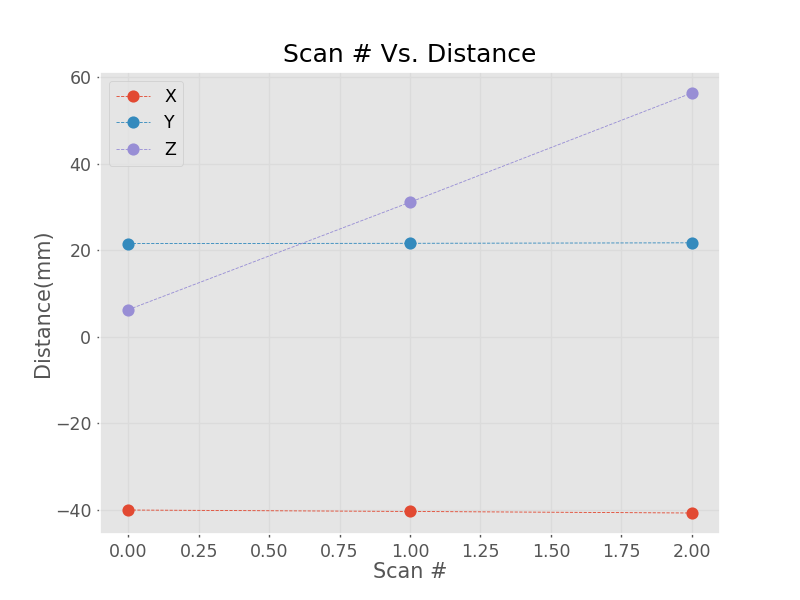

<IPython.core.display.Javascript object>


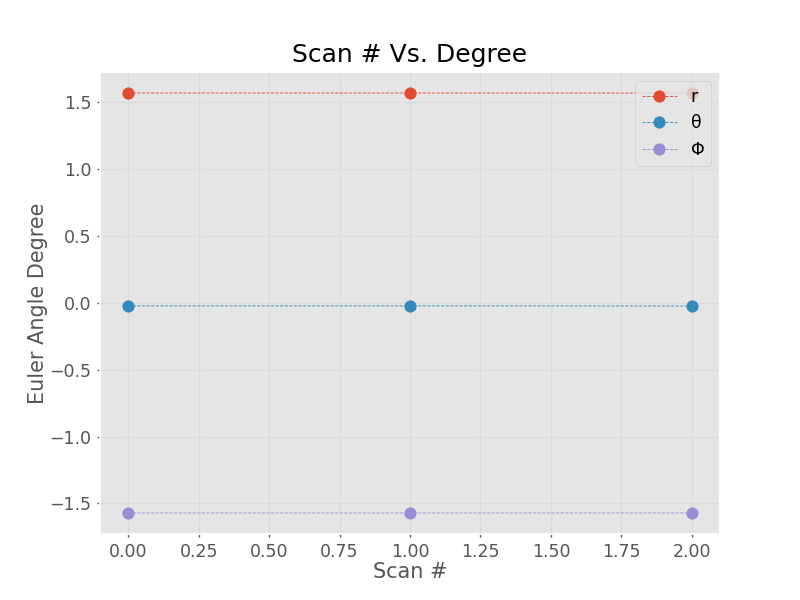

In [10]:
x_l = []
y_l = []
z_l = []
x_r = []
y_r = []
z_r = []
for x in new_data:
    Tbase = SE3(new_data[x][1].T)
    Tee = SE3(new_data[x][0].T)
    Tfinal = Tbase.inv()*Tee
    pos = Tfinal.t
    ros = R2E(Tfinal.R)
    x_l.append(pos[0])
    y_l.append(pos[1])
    z_l.append(pos[2])
    x_r.append(ros[0])
    y_r.append(ros[1])
    z_r.append(ros[2])
plot3l(x_l,y_l,z_l,False)
plot3l(x_r,y_r,z_r,True)

### TFK Verfied Plot

Postion Error norm(mm):  0.6027676394550517
Rotional Error norm(Euler Angle):  [ 8.30741828e-20 -1.35670436e-03  2.61290101e-04]
Postion Error norm(mm):  0.33006929892606507
Rotional Error norm(Euler Angle):  [ 9.50478199e-20 -1.55224870e-03  4.40179136e-04]
Postion Error norm(mm):  0.2086682545897886
Rotional Error norm(Euler Angle):  [ 1.16880888e-19 -1.90880975e-03  2.01097236e-04]


<IPython.core.display.Javascript object>


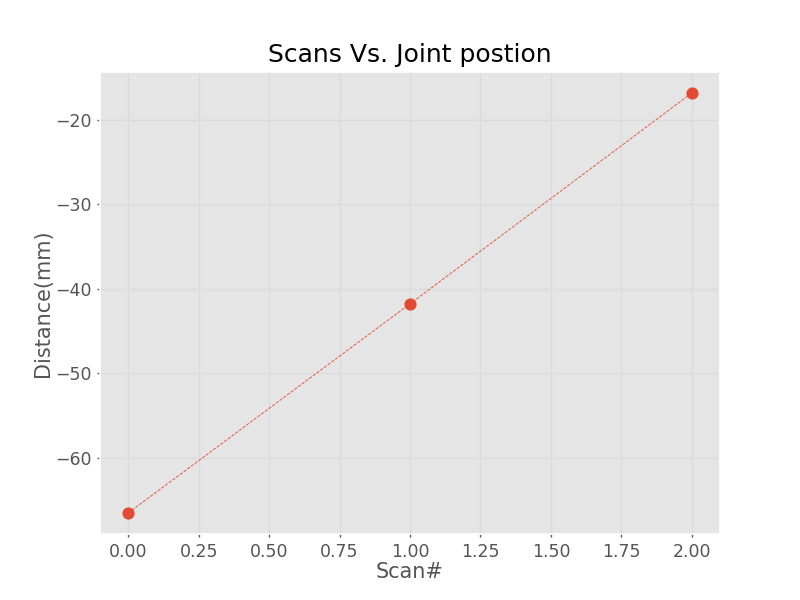

<IPython.core.display.Javascript object>


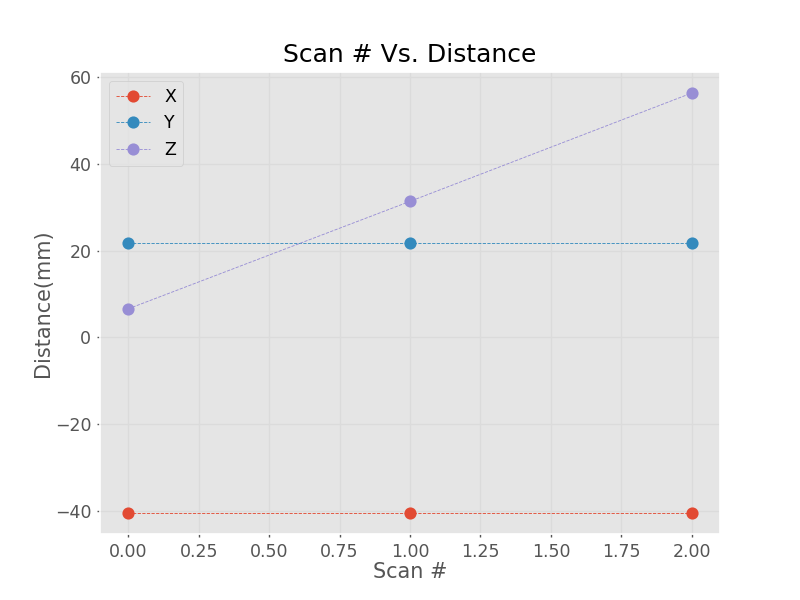

<IPython.core.display.Javascript object>


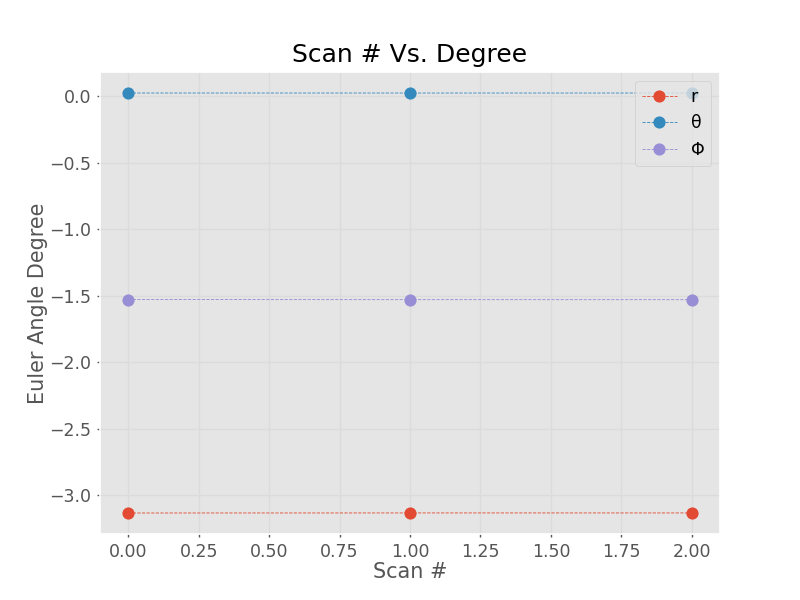

In [11]:
x_l = []
y_l = []
z_l = []
x_r = []
y_r = []
z_r = []
j_l = []
P_norm_list = []
P_list = []
P_std = []
for x in new_data:
    j_l.append(new_data[x][2].joint_postion)
    fk,r_error,p_error = find_fk(new_data[x][0],new_data[x][1],new_data[x][2])
    P_std.append(np.std(p_error))
    P_norm_list.append(np.linalg.norm(p_error))
    P_list.append(p_error)
    pos = (SE3(new_data[x][1].T).inv()*fk).t
    ros = R2E(fk.R)
    x_l.append(pos[0])
    y_l.append(pos[1])
    z_l.append(pos[2])
    x_r.append(ros[0])
    y_r.append(ros[1])
    z_r.append(ros[2])
plt.figure()
plt.plot(j_l,linestyle='--', marker='o')
plt.xlabel("Scan#")
plt.ylabel("Distance(mm)")
plt.title("Scans Vs. Joint postion")
plt.show()
plot3l(x_l,y_l,z_l,False)
plot3l(x_r,y_r,z_r,True)

### Tfk in 3D

In [ ]:
for x in range(len(new_data)):
    n = 'scan'+str(x)
    fk,_,_ = find_fk(new_data[n][0],new_data[n][1],new_data[n][2])
    display_fk(fk,new_data[n][0],mesh_l[x])

### Tfk plots

<IPython.core.display.Javascript object>


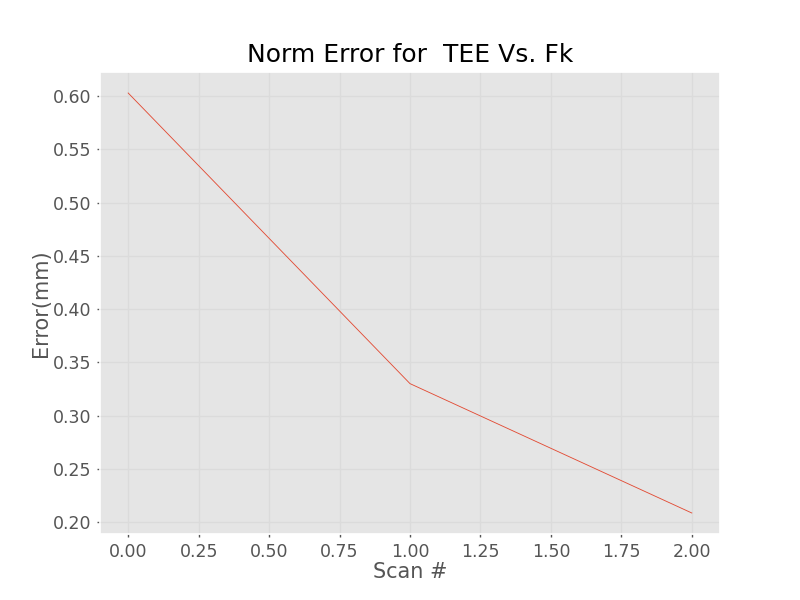

<IPython.core.display.Javascript object>


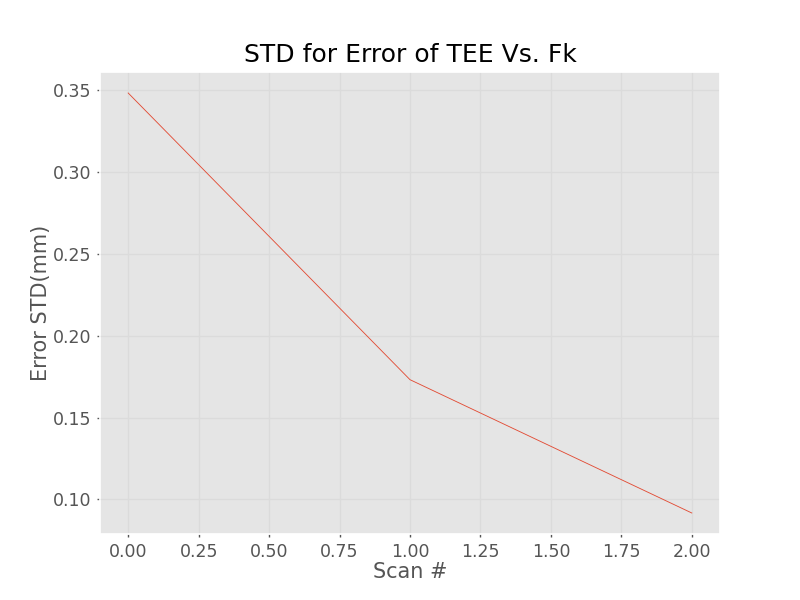

<IPython.core.display.Javascript object>


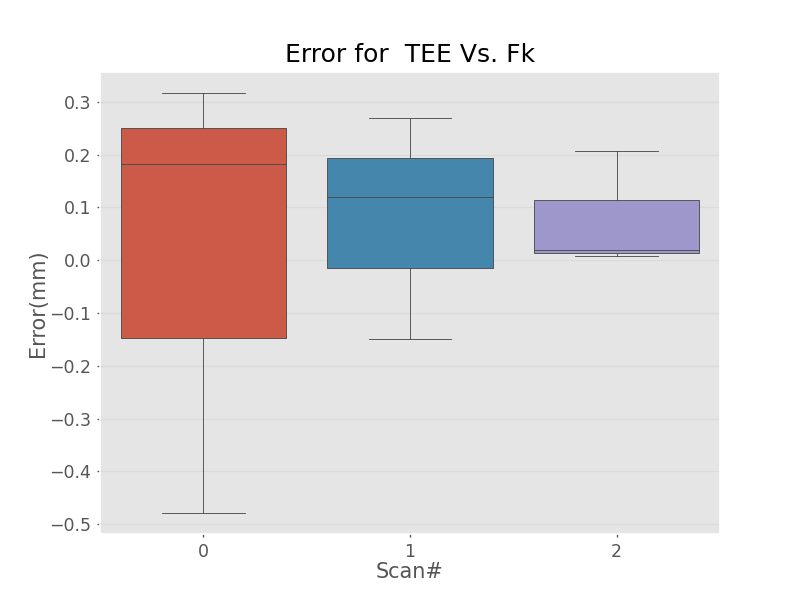

[Text(0.5, 1.0, 'Error for  TEE Vs. Fk'),
 Text(0, 0.5, 'Error(mm)'),
 Text(0.5, 0, 'Scan#')]

In [12]:
plt.plot(P_norm_list)
plt.title("Norm Error for  TEE Vs. Fk")
plt.ylabel("Error(mm)")
plt.xlabel("Scan #")
plt.figure()
plt.plot(P_std)
plt.title("STD for Error of TEE Vs. Fk")
plt.ylabel("Error STD(mm)")
plt.xlabel("Scan #")
plt.figure()
sns.boxplot(data=P_list,  orient='v').set(title='Error for  TEE Vs. Fk',ylabel="Error(mm)",xlabel="Scan#")